In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/blakewulfe/programming/research/ManiSkill2/mani_skill2/dough_model_learning/eval.py:64: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="film_unet")


In [94]:
import os

import hydra
from IPython.display import Image
import imageio
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import torch

from mani_skill2.dough_model_learning.eval import get_algo
from mani_skill2.dough_model_learning.visualize_rollouts import normalize_resize_heightmaps
from mani_skill2.utils.rollout import (
    generate_rollouts,
    save_sample_batch,
)

In [105]:
config_filepath = "/home/blakewulfe/programming/research/ManiSkill2/mani_skill2/dough_model_learning/config/film_unet.yaml"
config = OmegaConf.load(config_filepath)

w_loss_scaling = False

if w_loss_scaling:
    # w/ loss scaling
    prefix = "w"
    checkpoint_filepath = "/ssd1/datasets/robotics/tasks/model_based_dough_roll/training/dynamics/2023-03-02/17-56-33/checkpoints/last.ckpt"
else:
    # w/o loss scaling
    prefix = "wo"
    checkpoint_filepath = "/ssd1/datasets/robotics/tasks/model_based_dough_roll/training/dynamics/2023-03-06/09-02-54/checkpoints/last.ckpt"

config.eval.checkpoint = checkpoint_filepath

use_model = True
if not use_model:
    config.eval.checkpoint = None

In [106]:
env = hydra.utils.instantiate(config.eval.env)
algorithm = get_algo(env, config)
algorithm.verbose_info = True

[2023-03-08 09:48:10.914] [SAPIEN] [warning] A second engine will share the same internal structures with the first one. Arguments passed to constructor will be ignored.
[2023-03-08 09:48:10.914] [SAPIEN] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2023-03-08 09:48:10.914] [SAPIEN] [warning] Setting renderer more than once should be avoided.
2023-03-08 09:48:10,930 - mani_skill2 - INFO - load sdfs from file


In [107]:
def create_gif(imgs, filepath):
    imageio.mimsave(filepath, imgs, duration=0.5) 
    with open(filepath,"rb") as f:
        return Image(data=f.read(), format='png')

In [108]:
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

In [109]:
batches = generate_rollouts(
    env,
    algorithm,
    num_episodes=1,
    max_steps=5,
    render=True,
)

100%|████████████████████████████████████████████| 1/1 [00:32<00:00, 32.39s/it]


In [110]:
rew_state = batches["obs"][-1]
terminal_state_reward = rew_state[rew_state > 0].mean()
print(terminal_state_reward)

0.015039322


In [111]:
vizdir = "/home/blakewulfe/results/robotics/03_06_2023/planner_viz"

In [112]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_ground_truth_vs_pred_heightmaps(
        obs, 
        gt, 
        pred, 
        residual=None,
    ):
    fig, axs = plt.subplots(2, 3, figsize=(10,6))
    
    gt_residual = gt - obs
    
    def _plot_heightmap(ax, arr, title, vmin=None, vmax=None):
        ax.set_title(title)
        im = ax.imshow(arr, vmin=vmin, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    _plot_heightmap(axs[0,0], obs, "Observation")
    vmin = gt.min()
    vmax = gt.max()
    _plot_heightmap(axs[0,1], gt, "Next Observation", vmin, vmax)
    _plot_heightmap(axs[0,2], pred, "Predicted Next Observation", vmin, vmax)
    
    vmin = gt_residual.min()
    vmax = gt_residual.max()
    _plot_heightmap(axs[1,0], gt_residual, "Ground Truth Residual", vmin, vmax)
    
    if residual is not None:
        _plot_heightmap(axs[1,1], residual, "Predicted Residual", vmin, vmax)
        residual_error = gt_residual - residual
        _plot_heightmap(axs[1,2], residual_error, "Residual Error")

    plt.tight_layout()
    
    l2_loss = ((gt - pred) ** 2).sum()
    print(f"L2 Loss: {l2_loss: 0.4f}")

L2 Loss:  0.0983


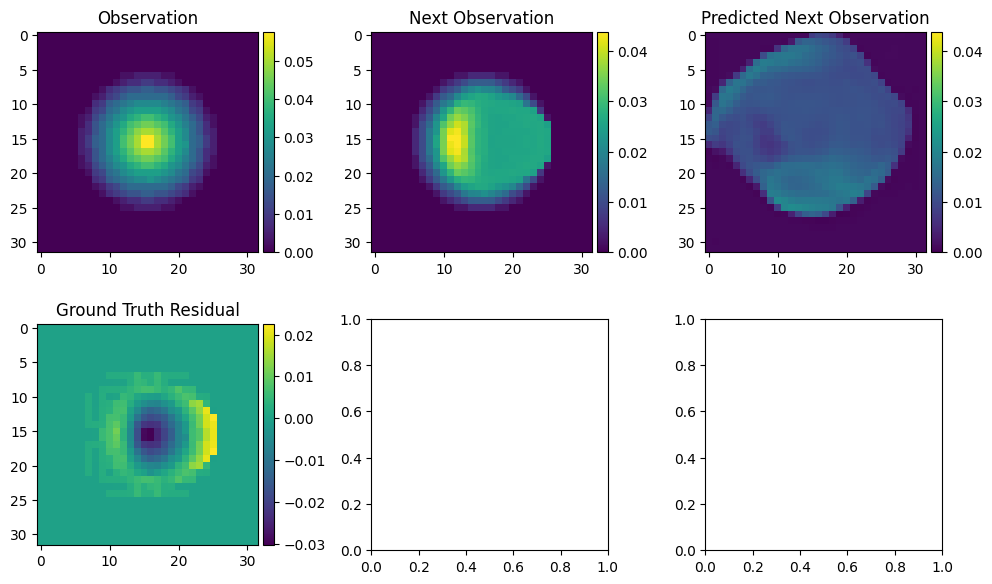

In [123]:
timestep = 0

dx = 5
obs = batches["obs"][timestep]
next_obs = batches["new_obs"][timestep]
agent_info = batches["infos"][timestep]["agent_info"]
pred_states = agent_info["state_sequence"].cpu().detach().numpy()
pred_obs = pred_states[dx]

plot_ground_truth_vs_pred_heightmaps(obs, next_obs, pred_obs)
plt.savefig(os.path.join(vizdir, f"render_{prefix}_loss_scaling_ep_{seed}_timestep_{timestep}.png"))

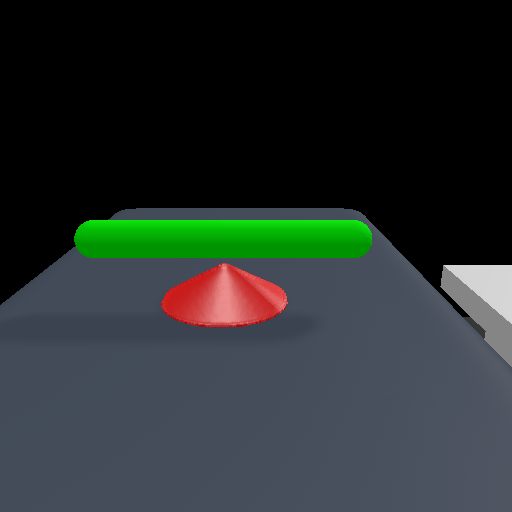

In [86]:
create_gif(batches["render"], os.path.join(vizdir, f"render_{prefix}_loss_scaling_{seed}_rew_{terminal_state_reward:0.4f}.gif"))